In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["science", "notebook", "grid", "dark_background"])
import itertools
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import matplotlib

In [4]:
ids = np.arange(1000)
r = np.random.uniform(0, 1, size=(len(ids), 2))
m = np.random.uniform(0, 1, size=len(ids))
rds = np.random.uniform(0, 1, size=len(ids))

def IsColliding(r1: np.ndarray, r2:np.ndarray, rd1:float, rd2:float):
    """ Check if two circles are colliding  
    Args:
    r1 : np.ndarray
        Position of the first circle
    r2 : np.ndarray
        Position of the second circle
    rd1 : float
        Radius of the first circle
    rd2 : float
        Radius of the second circle
    Returns:
    bool
        True if the circles are colliding
    """
    return np.linalg.norm(r1 - r2) < rd1 + rd2

In [12]:
class BilliardBalls:
    def __init__(self, N_particles, radius, v_thresold, masses, boundary, dt) -> None:
        """ Simulate billiard balls in a box 
        Args:
            N_particles (int): number of particles
            radius (float): radius of particles
            v_thresold (float): threshold velocity (m/s)
            masses (list): list of masses of particles
            boundary (float): boundary of the box
            dt (float): time step (s)
        Returns:
            None"""
        
        self.N_particles = N_particles # number of particles
        self.radius = radius # radius of particles
        self.dt = dt # time step (s)
        self.v_thresold = v_thresold # threshold velocity (m/s)
        self.masses = masses # list of masses of particles
        self.boundary = boundary # boundary of the box
        
        _ = np.random.uniform(-self.boundary, self.boundary, size=(self.N_particles))
        self.r = np.random.choice(a = _, size= (self.N_particles, 2)) # position of particles
        self.x = self.r[:, 0] # x position
        self.y = self.r[:, 1] # y position
        
        self.v = np.random.uniform(-self.v_thresold, self.v_thresold, size=(self.N_particles, 2)) # velocity of particles
        self.vx = self.v[:, 0] # x velocity
        self.vy = self.v[:, 1] # y velocity

        self.t = 0 # time (s)
        self.ids = np.arange(self.N_particles)

    def IsColliding(self, r1: np.ndarray, r2:np.ndarray, rd1:float, rd2:float) -> bool:
        """ Check if two circles are colliding  
        Args:
            r1 (np.ndarray): position of the first circle
            r2 (np.ndarray): position of the second circle
            rd1 (float): radius of the first circle
            rd2 (float): radius of the second circle
        Returns:
            bool: True if the circles are colliding"""
        return np.linalg.norm(r1 - r2) < (rd1 + rd2)

    def collide(self) -> None:
        """ Change velocity of colliding particles according to elastic collision 
        (momentum conservation and conservation of energy))"""

        # 3d array of all distances for all particle pairs
        r_ij = itertools.combinations(self.r, 2)

        # 2d array of all masses for all particle pairs
        m_ij = np.array(list(itertools.combinations(self.masses, 2))) 

        # 2d array of radii for all particle pairs
        rds_ij = itertools.combinations(self.radius, 2)

        # 2d array of all ids of particle pairs
        ids_ij = itertools.combinations(self.ids, 2)

        # 2d array of all ids of colliding particles
        ids_colliding = []
        for (r1, r2), (rad1, rad2), (id1, id2) in zip(r_ij, rds_ij, ids_ij):
            if self.IsColliding(r1, r2, rad1, rad2):
                ids_colliding.append((id1, id2))
        
        if len(ids_colliding) == 0:
            return None
        ids_colliding = np.array(ids_colliding) # 2d array of all ids of colliding particles

        # Old velocities of colliding particles
        v1_old = self.v[ids_colliding[:, 0]]
        v2_old = self.v[ids_colliding[:, 1]]

        # Masses of colliding particles
        m1 = m_ij[ids_colliding[:, 0]]
        m2 = m_ij[ids_colliding[:, 1]]

        # Position of the colliding particles
        r1 = self.r[ids_colliding[:, 0]]
        r2 = self.r[ids_colliding[:, 1]]

        # Change velocity of colliding particles, '@' is matrix multiplication
        self.v[ids_colliding[:, 0]] -= (2*m2/(m1 + m2)) * \
                                              (np.diag((v1_old - v2_old) @ \
                                                        (r1 - r2).T) / np.sum((r1 - r2)**2, axis=1))\
                                        .reshape(-1, 1) * (r1 - r2)
        self.v[ids_colliding[:, 1]] -= (2*m1/(m1 + m2)) * \
                                              (np.diag((v2_old - v1_old) @ \
                                                        (r2 - r1).T) / np.sum((r1 - r2)**2, axis=1))\
                                        .reshape(-1, 1) * (r2 - r1)

    def check_boundary(self) -> None:
        """ Change velocity of particles that hit the boundary """
        self.vx[(self.x >= self.boundary) | (self.x <= -self.boundary)] *= -1 # change x velocity of particles that hit the boundary
        self.vy[(self.y >= self.boundary) | (self.y <= -self.boundary)] *= -1 # change y velocity of particles that hit the boundary

    def update(self) -> None:
        """ Update position and velocity of particles """
        self.check_boundary() # check if particles hit the boundary
        self.collide() # check if particles collide
        self.r += self.v * self.dt # update position
        self.t += self.dt  # update time

    def __str__(self) -> str:
        return f"""
        Number of particles: {self.N_particles},
        Radius of particles: {np.unique(self.radius)},
        Threshold velocity: {self.v_thresold},
        Time step: {self.dt},
        Masses: {np.unique(self.masses)}
        """

In [13]:
N_PARTICLES = 100 # number of particles
MASSES = np.full(N_PARTICLES, 1) # masses of particles
MASSES[-1] = 100  # mass of last particle
RADII = np.full(N_PARTICLES, 0.1) # radii of particles
RADII[-1] = 0.5 # radius of last particle

# Create billiard balls
balls = BilliardBalls(N_PARTICLES, RADII, 10, MASSES, 5, 0.007)
print(balls)


        Number of particles: 100,
        Radius of particles: [0.1 0.5],
        Threshold velocity: 10,
        Time step: 0.007,
        Masses: [  1 100]
        


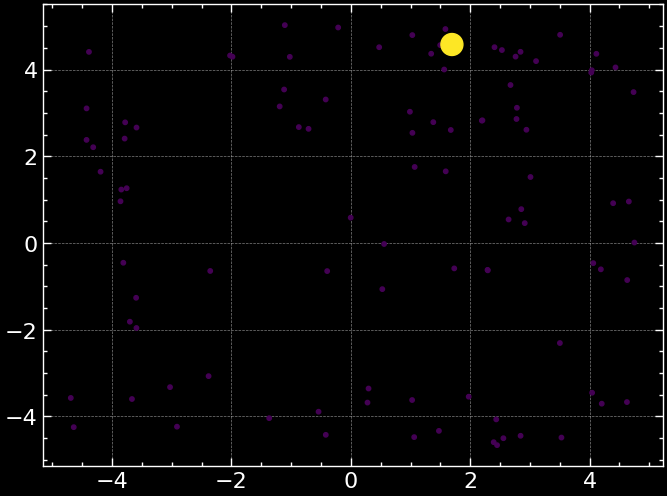

In [15]:
balls.update()
plt.scatter(balls.x, balls.y, s=1000*balls.radius**2, c=balls.masses)

MovieWriter imagemagick unavailable; using Pillow instead.


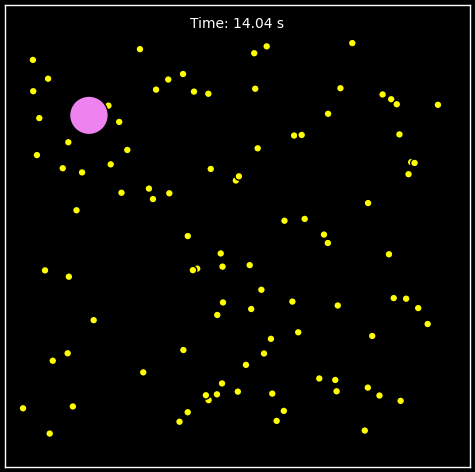

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
colors = ["violet" if m == max(balls.masses) else "yellow" for m in balls.masses]

def animate(i):
    ax.clear()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

    balls.update()
    
    circ = [plt.Circle((x, y), r, color = color) for x, y, r, color in 
                        zip(balls.x, balls.y, balls.radius, colors)]
    circles = matplotlib.collections.PatchCollection(circ,  match_original=True,
                    edgecolor="black")
    ax.add_collection(circles)
    ax.text(0, 5.5, f"Time: {balls.t:.2f} s", ha="center", va="center")

anim = FuncAnimation(fig, animate, frames=1000, interval=50)
anim.save("billiard_balls.gif", writer="imagemagick", fps=10)